<p float="left">
  <img src="immo_scout24.png" width="400" />
  <img src="immo.png" width="400" />
</p>


###### <center><h1>PROJEKTARBEIT</h1></center>
### <center><h2>ANALYSE des IMMOSCOUT-DATENSATZES</h2></center>
#### <center><h3>TEIL 2 - UMGANG mit FEHLENDEN WERTEN</h3></center>

**Projektarbeit-Alfatrining / Herr Axel Wemmel**

**[Nurdan Cakir]**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact, Dropdown, IntSlider, Output, widgets
# from IPython.core.display import display
from IPython.display import display
from termcolor import colored
import re

from skimpy import clean_columns
# import requests
# import geopy
# from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [ ]:
df0 = pd.read_csv("cleaned_immo_data.csv")
df = df0.copy()

In [ ]:
df.head(3).T

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def check_obj_columns(df):
    '''
    Gibt "KEIN PROBLEM" oder die Spalte(n) zurück, die gemischte Objekttypen enthalten.
    '''    
    
    tdf = df.select_dtypes(include=['object']).applymap(type)
    for col in tdf:
        if len(set(tdf[col].values)) > 1:
            print("Column" + " " + color.BOLD + color.RED + col + color.END + " " + "hat gemischte Objekttypen." )
    else:
        if len(set(tdf[col].values)) == 1:
            print(color.BOLD + color.GREEN + " " + "KEIN PROBLEM" + " " + color.END + " " + "mit der datentypen der Spalten in die DataFrame.")

check_obj_columns(df)

# 1. Umgang mit fehlenden Werten (Missing Value Treatment)

## 1.1. Überprüfung auf fehlende Werte:

In [ ]:
missing_percentage = df.isnull().sum()*100 / df.shape[0]

In [ ]:
# Hier werden alle Spalten, die mindestens einen fehlenden Wert enthalten, mithilfe von List Comprehension in einer Liste gesammelt.
# Anschließend wird der prozentuale Anteil der fehlenden Werte jeder Spalte im Output dargestellt.

miss_val = []
[miss_val.append(column) for column in df.columns if any(df[column].isnull())]

missing_percentage = df[miss_val].isnull().sum()*100 / df[miss_val].shape[0]
missing_percentage = missing_percentage.sort_values(ascending=False)
print("Spalten, der fehlenden Werte haben:")
print("---"*11)
print(f"{miss_val}\n\n{missing_percentage}")

In [ ]:
def df_nans(df, limit):
    """
   Gibt eine Pandas Series zurück, die den Prozentsatz der fehlenden Werte in jeder Spalte des übergebenen DataFrames 'df' enthält, 
sofern dieser den angegebenen 'limit'-Schwellenwert überschreitet.

Parameter:
----------
df : pandas.DataFrame
    Der DataFrame, der auf fehlende Werte untersucht werden soll.
limit : float
    Der Schwellenwert (in Prozent), ab dem eine Spalte als zu viele fehlende Werte enthaltend betrachtet wird.

Rückgabewert:
-------------
pandas.Series
    Eine Series mit dem Prozentsatz der fehlenden Werte in den Spalten von 'df', die den angegebenen 'limit' überschreiten.
    Falls keine Spalte den Grenzwert überschreitet, wird eine entsprechende Nachricht als Zeichenkette zurückgegeben.
    """
    missing = df.isnull().sum()*100 / df.shape[0]
    missing = missing.loc[lambda x : x >= limit]
    if missing.empty:
        return "Keine Spalten haben fehlende Werte, den Grenzwert überschreitet."
    else:
        return missing

def show_missing_values(limit):
    return df_nans(df, limit)

def column_nans(serial):
    # Prozentsatz der fehlenden Werte (NaNs) in einer Series anzeigen
    return serial.isnull().sum()*100 / serial.shape[0]

## 1.2. Überprüfung auf doppelte Zeilen

In [ ]:
df.astype(str).duplicated(keep=False).sum()
# prüft, ob es doppelte Zeilen im DataFrame gibt, und zwar so, dass alle Werte als Zeichenkette (str) betrachtet werden. 
# Das ist nützlich, wenn z. B. Zahlen und Objekte gemischt sind oder kleine Formatunterschiede vorliegen könnten.

# Ergebnis: 0
# Das bedeutet, dass keine doppelten Zeilen im gesamten DataFrame vorhanden sind.

## 1.3. Strategien zum Umgang mit NaNs
✔️ Numerische Merkmale: Durchschnitt, Median, Modus oder modellbasierte Imputation

✔️ Kategorische Merkmale: Modus, separate Kategorie („unbekannt“)

✔️ Boolesche Merkmale: True/False basierend auf Kontext oder Default-Wert

✔️ Zeit- oder Ortsdaten: ggf. aus anderen Spalten rekonstruieren oder ignorieren

## 1.4. Benutzerdefinierte Funktionen zum Auffüllen der fehlenden Werte:


### 1.4.1. first_looking(col)

In [ ]:
def first_looking(*cols):
    """
    Prints basic information about given columns in a Pandas DataFrame.

    Parameters:
    *cols (str): The names of the columns to analyze.

    Returns:
    None.

    Prints:
    - The name of each column.
    - The percentage of null values in each column.
    - The number of null values in each column.
    - The number of unique values in each column.
    - The value counts for each unique value in each column, including null values.
    """
    for col in cols:
        print("COLUMN NAME    : ", col)
        print("--------------------------------")
        print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
        print("num_of_nulls   : ", df[col].isnull().sum())
        print("num_of_uniques : ", df[col].nunique())
        print("--------------------------------")
        print(df[col].value_counts(dropna=False))
        print("\n")

Dies ist eine benutzerdefinierte Python-Funktion namens first_looking, die einen Spaltennamen als Eingabe (col) entgegennimmt. Die Funktion dient der ersten Analyse einer bestimmten Spalte in einem Pandas DataFrame (df).

Zunächst gibt die Funktion den Namen der Spalte aus, gefolgt von einer Linie aus Bindestrichen zur besseren Lesbarkeit. Danach berechnet und gibt sie folgende Kennzahlen aus:

✔️ den Prozentsatz fehlender Werte in der Spalte (per_of_nulls),

✔️ die Anzahl fehlender Werte in der Spalte (num_of_nulls),

✔️ sowie die Anzahl der eindeutigen Werte in der Spalte (num_of_uniques),

jeweils in einer eigenen Zeile.

Anschließend folgt erneut eine Trennlinie aus Bindestrichen. Danach wird mit Hilfe der Pandas-Methode value_counts() die Häufigkeit jedes eindeutigen Wertes in der Spalte ausgegeben – inklusive eventuell vorhandener NaN-Werte. Dies hilft dabei, häufige Werte, Ausreißer oder potenzielle Datenprobleme (z. B. fehlende oder fehlerhafte Angaben) schnell zu erkennen.

Insgesamt bietet die Funktion first_looking eine einfache und effiziente Möglichkeit, sich einen ersten Überblick über eine bestimmte Spalte in einem DataFrame zu verschaffen – inklusive grundlegender statistischer Informationen und Wertverteilungen.

### 1.4.2. plot_all_categorical_distributions

In [ ]:
import plotly.express as px

def plot_categorical_distributions(df, column=None):
    """
    Eğer column parametresi verilirse sadece o sütunun dağılımını,
    verilmezse DataFrame'deki tüm kategorik sütunların dağılımını çizer.
    """
    if column:
        columns_to_plot = [column]
    else:
        columns_to_plot = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in columns_to_plot:
        fig = px.histogram(
            df,
            x=col,
            title=f'Distribution of {col}',
            labels={col: col, 'count': 'Count'},
            color_discrete_sequence=['#636EFA']
        )
        fig.update_layout(xaxis_tickangle=45)
        fig.show()


### 1.4.3. plot_numeric_distribution

In [ ]:
import plotly.express as px

def plot_numeric_distributions(df, column=None):
    """
   Wenn der Spaltenparameter angegeben ist, wird nur die Verteilung dieser Spalte dargestellt. 
   Wenn nicht, wird die Verteilung aller numerischen Spalten im DataFrame dargestellt.
    """
    if column:
        columns_to_plot = [column]
    else:
        columns_to_plot = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    for col in columns_to_plot:
        fig = px.histogram(
            df,
            x=col,
            title=f'Verteilung von {col}', 
            labels={col: col, 'count': 'Anzahl'},
            color_discrete_sequence=['#00CC96']
        )
        fig.update_layout(xaxis_title=col, yaxis_title='Anzahl')
        fig.show()


### 1.4.4. fill_most_freq(df, group_col, col_name)

In [ ]:
def fill_most_freq(df, group_col, col_name):
    """
    Fills missing values in a column of a Pandas DataFrame `df` with the most frequent value 
    in each group defined by a grouping column.

    Parameters:
    df (pandas.DataFrame): The DataFrame to operate on.
    group_col (str): The name of the grouping column.
    col_name (str): The name of the column to fill missing values in.

    Returns:
    None.

    Prints:
    - The name of the column that was filled.
    - The percentage of null values in the column after filling.
    - The number of null values in the column after filling.
    - The number of unique values in the column after filling.
    - The value counts for each unique value in the column after filling, including null values, sorted by index.
    """    
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False).sort_index())

Dies ist eine benutzerdefinierte Python-Funktion (DEF) mit dem Namen fill_most_freq, die drei (3) Eingabeparameter entgegennimmt:

✔️ einen Pandas DataFrame (df),

✔️ den Namen einer Gruppierungsspalte (group_col),

✔️ sowie den Namen der Spalte, in der fehlende Werte gefüllt werden sollen (col_name).

Die Funktion verwendet eine for-Schleife, um fehlende Werte in einer bestimmten Spalte (col_name) abhängig von den Werten in einer anderen Spalte (group_col) zu füllen. Die einzelnen Schritte innerhalb der Schleife:

✔️ for group in list(df[group_col].unique()):
Diese Zeile iteriert über alle eindeutigen Werte in der Gruppierungsspalte group_col. Jeder eindeutige Gruppenwert wird in der Variable group gespeichert.

✔️ cond = df[group_col]==group:
Hier wird eine boolesche Bedingung (cond) erstellt, die True für alle Zeilen ist, bei denen der Wert in group_col gleich dem aktuellen Gruppenwert ist.

✔️ mode = list(df[cond][col_name].mode()):
Diese Zeile berechnet den Modus (häufigster Wert) der Spalte col_name innerhalb der aktuellen Gruppe (cond). Das Ergebnis wird als Liste in der Variable mode gespeichert.

✔️ if mode != []:
Überprüfung, ob der Modus existiert (also keine leere Liste ist).

✔️ df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0]):
Falls ein Modus vorhanden ist, werden die fehlenden Werte in der Spalte col_name innerhalb der aktuellen Gruppe mit diesem häufigsten Wert gefüllt.

✔️ else:
Falls kein Modus innerhalb der Gruppe gefunden wurde (z. B. weil alle Werte fehlen), wird ein alternativer Füllwert verwendet:

✔️ df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0]):
In diesem Fall werden die fehlenden Werte mit dem Modus der gesamten Spalte (col_name) über den gesamten DataFrame gefüllt.

### 1.4.5. fill_mode(df, group_col1, group_col2, col_name)

In [ ]:
def fill_mode(df, group_col1, group_col2, col_name):
    """
    Fills missing values in a column of a Pandas DataFrame `df` based on the values in two other columns.

    Parameters:
    df (pandas.DataFrame): The DataFrame to operate on.
    group_col1 (str): The name of the first grouping column.
    group_col2 (str): The name of the second grouping column.
    col_name (str): The name of the column to fill missing values in.

    Returns:
    None.

    Prints:
    - The name of the column that was filled.
    - The percentage of null values in the column after filling.
    - The number of null values in the column after filling.
    - The number of unique values in the column after filling.
    - The value counts for each unique value in the column after filling, including null values.
    """    
    for group1 in list(df[group_col1].unique()):
        for group2 in list(df[group_col2].unique()):
            cond1 = df[group_col1]==group1
            cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
            mode1 = list(df[cond1][col_name].mode())
            mode2 = list(df[cond2][col_name].mode())
            if mode2 != []:
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
            elif mode1 != []:
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
            else:
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
    
    print("column name    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

Dies ist eine benutzerdefinierte Python-Funktion (DEF) mit dem Namen fill_mode, die vier (4) Eingabeparameter verwendet:

✔️ Ein Pandas DataFrame (df),

✔️ den Namen einer Gruppierungsspalte (group_col1),

✔️ den Namen einer weiteren Gruppierungsspalte (group_col2),

✔️ und den Namen der Spalte, in der fehlende Werte aufgefüllt werden sollen (col_name).

Die Funktion verwendet eine geschachtelte for-Schleife, um fehlende Werte in einer bestimmten Spalte (col_name) basierend auf den Kombinationen von zwei Gruppierungsspalten (group_col1, group_col2) zu füllen. Hier die Erklärung der einzelnen Schritte:

✔️ for group1 in list(df[group_col1].unique()):
Iteration über alle eindeutigen Werte in group_col1. Jeder Wert wird in group1 gespeichert.

✔️ for group2 in list(df[group_col2].unique()):
Für jeden group1-Wert werden nun alle eindeutigen group2-Werte durchlaufen.

✔️ cond1 = df[group_col1]==group1:
Erstellt eine boolesche Bedingung (cond1), die True ist, wenn der Wert in group_col1 dem aktuellen group1 entspricht.

✔️ cond2 = (df[group_col1]==group1) & (df[group_col2]==group2):
Erstellt eine weitere Bedingung (cond2), die True ist, wenn sowohl group1 als auch group2 auf eine Zeile zutreffen. Diese Bedingung gilt für die Kombination beider Gruppenwerte.

✔️ mode1 = list(df[cond1][col_name].mode()):
Berechnet den Modus (häufigster Wert) der Spalte col_name für die Bedingung cond1 (also alle Zeilen mit dem aktuellen group1).

✔️ mode2 = list(df[cond2][col_name].mode()):
Berechnet den Modus für die Zeilen, die sowohl group1 als auch group2 entsprechen.

✔️ if mode2 != []:
Wenn ein Modus für die Kombination aus group1 und group2 gefunden wurde:

✔️ df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(mode2[0])
➤ Fehlt ein Wert in dieser Gruppe, wird er mit dem gruppenspezifischen Modus (mode2) aufgefüllt.

✔️ elif mode1 != []:
Wenn kein mode2, aber ein mode1 verfügbar ist:

✔️ df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(mode1[0])
➤ Fehlt ein Wert, wird er mit dem Modus von group1 allein gefüllt.

✔️ else:
Wenn weder mode2 noch mode1 verfügbar sind:

✔️ df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
➤ Dann wird der Wert mit dem allgemeinen Modus der gesamten Spalte col_name gefüllt.

### 1.4.6. fill_prop(df, group_col, col_name)

In [ ]:
def fill_prop(df, group_col, col_name):
    """
    Fills missing values in a column of a Pandas DataFrame `df` using forward and backward fill based on a grouping column.

    Parameters:
    df (pandas.DataFrame): The DataFrame to operate on.
    group_col (str): The name of the grouping column.
    col_name (str): The name of the column to fill missing values in.

    Returns:
    None.

    Prints:
    - The name of the column that was filled.
    - The percentage of null values in the column after filling.
    - The number of null values in the column after filling.
    - The number of unique values in the column after filling.
    - The value counts for each unique value in the column after filling, including null values, sorted by index.
    """    
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False).sort_index())

Dies ist eine benutzerdefinierte Python-Funktion (DEF) mit dem Namen fill_prop, die drei (3) Eingabeparameter verwendet:

✔️ Ein Pandas DataFrame (df),

✔️ den Namen einer Gruppierungsspalte (group_col),

✔️ und den Namen der Spalte, in der fehlende Werte aufgefüllt werden sollen (col_name).

Die Funktion verwendet eine for-Schleife, um fehlende Werte gruppenweise in einer bestimmten Spalte zu füllen. Das passiert in folgenden Schritten:

✔️ for group in list(df[group_col].unique()):
➤ Diese Zeile durchläuft alle eindeutigen Werte der Gruppierungsspalte group_col. Jeder Gruppenwert wird in der Variablen group gespeichert.

✔️ cond = df[group_col]==group:
➤ Erstellt eine boolesche Maske namens cond, die für alle Zeilen True ist, bei denen der Wert in group_col dem aktuellen Gruppenwert group entspricht.

✔️ df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill"):
➤ Für alle Zeilen der aktuellen Gruppe werden die fehlenden Werte in col_name zuerst mit dem vorherigen (forward fill) und dann mit dem nachfolgenden (backward fill) Wert aufgefüllt. So wird sichergestellt, dass innerhalb der Gruppe fehlende Werte mit möglichst naheliegenden, vorhandenen Werten ersetzt werden.

✔️ df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill"):
➤ Diese Zeile füllt alle übrigen fehlenden Werte (die nicht durch Gruppenzugehörigkeit aufgefüllt werden konnten) auf gesamter DataFrame-Ebene mit der gleichen Methode (vorwärts, dann rückwärts).

### 1.4.7. fill(df, group_col1, group_col2, col_name, method)

In [ ]:
def fill(df, group_col1, group_col2, col_name, method):
    """
    Fills missing values in a column of a Pandas DataFrame `df` based on double-stage grouping and a specified filling method.

    Parameters:
    df (pandas.DataFrame): The DataFrame to operate on.
    group_col1 (str): The name of the first grouping column.
    group_col2 (str): The name of the second grouping column.
    col_name (str): The name of the column to fill missing values in.
    method (str): The filling method to use. Can be "mode", "mean", "median", "ffill", or "bfill".

    Returns:
    None.

    Prints:
    None.
    """
    
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])

    elif method == "mean":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df[col_name].mean(), inplace = True)
        
    elif method == "median":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df[col_name].median(), inplace = True)
        
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False).sort_index())

Dies ist eine benutzerdefinierte Python-Funktion (DEF) namens fill, die fünf (5) Eingabeparameter verwendet:

✔️ Ein Pandas DataFrame (df),

✔️ den Namen einer ersten Gruppierungsspalte (group_col1),

✔️ den Namen einer zweiten Gruppierungsspalte (group_col2),

✔️ den Namen der Zielspalte, in der fehlende Werte aufgefüllt werden sollen (col_name),

✔️ und die Methode (method), mit der die fehlenden Werte gefüllt werden sollen.

Mögliche Methoden:
Der Parameter method kann einen der folgenden vier Werte annehmen:

✔️ "mode": häufigster Wert (Modus),

✔️ "mean": Durchschnitt (Mittelwert),

✔️ "median": Median,

✔️ "ffill": vorwärts auffüllen (forward fill).

Funktionsweise im Detail:
1.  Zweck der Funktion:
Die Funktion soll fehlende Werte in der Spalte col_name auffüllen – dabei wird zweistufig gruppiert nach group_col1 und group_col2.

2.  Wenn method == "mode":
➤ Die Funktion durchläuft mit zwei verschachtelten Schleifen alle Kombinationen der eindeutigen Werte aus group_col1 und group_col2.
➤ Fehlende Werte in col_name werden durch den Modus der jeweiligen Gruppe ersetzt.

3. Wenn method == "mean" oder "median":
➤ Fehlende Werte werden in drei Schritten gefüllt:

    ✔️ Zuerst gruppiert nach beiden Spalten (group_col1 & group_col2),

    ✔️ Dann nur nach group_col1,

    ✔️ Zum Schluss im gesamten DataFrame.

4. Wenn method == "ffill":
➤ Die Funktion verwendet wieder zwei verschachtelte Schleifen über alle Gruppen-Kombinationen.
➤ Innerhalb jeder Gruppe werden die fehlenden Werte in col_name mithilfe von vorwärts (ffill) und anschließend rückwärts (bfill) aufgefüllt.
➤ Danach wird das gleiche Verfahren auf den gesamten DataFrame angewendet, um eventuell verbliebene NaNs zu füllen.

Nach der Verarbeitung:
Unabhängig von der Methode gibt die Funktion zum Schluss Zusammenfassungsstatistiken zur Spalte col_name aus:

✔️ Prozentsatz der fehlenden Werte,

✔️ Anzahl der fehlenden Werte,

✔️ Anzahl der eindeutigen Werte,

✔️ Häufigkeitsverteilung der Werte (inkl. NaN, falls vorhanden), aufsteigend nach Index sortiert.

## 1.5. Untersuchung der fehlenden Werte in den Spalten


In [ ]:
df_notnull = df[df.columns[~df.isnull().any()]]
df_notnull.columns

In [ ]:
for col in df_notnull.columns:
    print(first_looking(col))
    print()

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

### 1.5.1. service_charge

In [ ]:
first_looking("service_charge")

In [ ]:
px.box(df, y='service_charge')

In [ ]:
fill(df, "regio_2", "living_space", "service_charge", method="mean")

### 1.5.2. total_rent

In [ ]:
first_looking("total_rent")

In [ ]:
px.violin(df, y='total_rent', box=True)

In [ ]:
mask = df['total_rent'].isna() & df['base_rent'].notna() & df['service_charge'].notna()
df.loc[mask, 'total_rent'] = df.loc[mask, 'base_rent'] + df.loc[mask, 'service_charge']

In [ ]:
df['total_rent'].isna().sum()

**💡Imputation der Spalte „total_rent“:**
Die fehlenden Werte in der Spalte total_rent wurden zuerst mit der Summe aus base_rent und service_charge aufgefüllt, sofern beide Werte vorhanden waren. Für die verbleibenden fehlenden Werte erfolgte anschließend eine Imputation mittels des Medianwerts, gruppiert nach den Kategorien region_combo und living_space. Diese Vorgehensweise gewährleistet eine realistische und differenzierte Schätzung der fehlenden Mietwerte unter Berücksichtigung regionaler Unterschiede und Wohnflächengrößen.

### 1-5.3. heating_costs

In [ ]:
first_looking("heating_costs")

In [ ]:
px.violin(df, y='base_rent', box=True)

In [ ]:
df_test = df[['base_rent', 'service_charge', 'total_rent']].dropna()
df_test['calc_total'] = df_test['base_rent'] + df_test['service_charge']
df_test['match'] = df_test['calc_total'] == df_test['total_rent']
print(df_test['match'].value_counts())

In [ ]:
# 1. Filter: Nur Zeilen, bei denen 'heating_costs' fehlt, aber 'base_rent', 'service_charge' und 'total_rent' vorhanden sind
mask = (
    df['heating_costs'].isna() &
    df['base_rent'].notna() &
    df['service_charge'].notna() &
    df['total_rent'].notna()
)

# 2. Berechne den fehlenden Betrag: total_rent - base_rent - service_charge
calc = df['total_rent'] - df['base_rent'] - df['service_charge']

# 3. Nur sinnvolle Werte übernehmen (heating_costs soll nicht negativ sein)
df.loc[mask & (calc >= 0), 'heating_costs'] = calc[mask & (calc >= 0)]

In [ ]:
df['heating_costs'].isna().sum()

In [ ]:
print(mask.sum())  # Wie viele Zeilen werden True?
print(df[mask].head())

In [ ]:
# erstell bins für Living space (z.B. 0–50, 50–100, 100–150, ...)
bins = list(range(0, int(df['living_space'].max()) + 50, 50))
labels = [f"{i}-{i+50}" for i in bins[:-1]]
df['living_space_bin'] = pd.cut(df['living_space'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
mask = df['heating_costs'].isna()

group_median = df.groupby(['region_combo', 'living_space_bin'])['heating_costs'].median()

df.loc[mask, 'heating_costs'] = df[mask].apply(
    lambda row: group_median.get((row['region_combo'], row['living_space_bin'])),
    axis=1
)

In [ ]:
df['heating_costs'].isna().sum()

In [ ]:
df['heating_costs'] = df.groupby('region_combo')['heating_costs'].transform(
    lambda x: x.fillna(x.median())
)

In [ ]:
df['heating_costs'].isna().sum()

In [ ]:
df["heating_costs"].fillna(df["heating_costs"].median(), inplace=True)

In [ ]:
df['heating_costs'].isna().sum()

In [ ]:
df.drop(columns=["living_space_bin"], inplace=True)

### 1.5.4. telekom_tv_offer

In [ ]:
first_looking("telekom_tv_offer")

In [ ]:
plot_categorical_distributions(df, 'telekom_tv_offer')

In [ ]:
df["telekom_tv_offer"] = df.groupby("region_combo")["telekom_tv_offer"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [ ]:
df["telekom_tv_offer"].isna().sum()

In [ ]:
if df["telekom_tv_offer"].isnull().sum() > 0:
    global_mode = df["telekom_tv_offer"].mode().iloc[0]
    df["telekom_tv_offer"] = df["telekom_tv_offer"].fillna(global_mode)

In [ ]:
# df["telekom_tv_offer"] = df["telekom_tv_offer"].fillna("ONE_YEAR_FREE")

In [ ]:
df["telekom_tv_offer"].isna().sum()

**💡Die Spalte `telekom_tv_offer`**, wurde stattdessen nur nach `regio_3` gruppiert. Für verbleibende fehlende Werte wurde der globale Modus der Spalte `telekom_tv_offer` verwendet. So konnte eine sinnvolle und stabile Imputation der fehlenden Werte gewährleistet werden, ohne bestehende gültige Daten zu überschreiben.


### 1.5.5. year_constructed

In [ ]:
first_looking("year_constructed")

In [ ]:
df["year_constructed"] = df["year_constructed"].astype("Int64")

In [ ]:
def extract_year(text):
    text = str(text)
    
    # Pattern 1: anahtar kelime sonra yıl (aralarında 0-20 karakter olabilir)
    pattern1 = r"(?i)(baujahr|erbaut|errichtet|gebaut).{0,20}?(\d{4})"
    # Pattern 2: yıl sonra anahtar kelime (aralarında 0-20 karakter olabilir)
    pattern2 = r"(?i)(\d{4}).{0,20}?(Bj.|baujahr|erbaut|errichtet|gebaut)"
    
    match1 = re.search(pattern1, text)
    if match1:
        return int(match1.group(2))
    
    match2 = re.search(pattern2, text)
    if match2:
        return int(match2.group(1))
    
    return np.nan


In [ ]:
df['extracted_year'] = df['description'].apply(extract_year)

In [ ]:
df['year_constructed'] = df['year_constructed'].fillna(df['extracted_year'])

In [ ]:
first_looking("year_constructed")

In [ ]:
df.drop(columns=["extracted_year"], inplace=True)

In [ ]:
def categorize_year(year):
    if pd.isna(year):
        return 'unknown'
    elif year >= 2015:
        return 'very_new'
    elif year >= 2000:
        return 'new'
    elif year >= 1980:
        return 'moderate'
    elif year >= 1950:
        return 'old'
    elif year >= 1800:
        return 'very_old'
    else:
        return 'historical'

df['year_category'] = df['year_constructed'].apply(categorize_year)

In [ ]:
df['year_category'].value_counts()

In [ ]:
plot_categorical_distributions(df, 'year_category')

### 1.5.6. no_park_spaces

In [ ]:
first_looking("no_park_spaces")

In [ ]:
px.violin(df, y='no_park_spaces', box=True)

**💡Die Spalte no_park_spaces,** welche die Anzahl der Parkplätze pro Immobilie angibt, wies einen sehr hohen Anteil an fehlenden Werten auf:
65,51 % der Werte (entsprechend 174.936 Einträgen) waren NaN.

Da diese Information potenziell mit der Region sowie dem Wohnungstyp zusammenhängt, wurde ein gestuftes Verfahren zur Imputation (Wertauffüllung) angewendet.

In [ ]:
# 1. Gruppierung nach regio_3 und type_of_flat:
df["no_park_spaces"] = df.groupby(["region_combo", "type_of_flat"])["no_park_spaces"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [ ]:
df["no_park_spaces"].isna().sum()

In [ ]:
# 2. Falls weiter fehlende Werte vorhanden waren:
df["no_park_spaces"] = df.groupby("region_combo")["no_park_spaces"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [ ]:
df["no_park_spaces"].isna().sum()

In [ ]:
# 3. Letzter Schritt – globale Imputation:
if df["no_park_spaces"].isnull().sum() > 0:
    overall_mode = df["no_park_spaces"].mode()
    if not overall_mode.empty:
        df["no_park_spaces"] = df["no_park_spaces"].fillna(overall_mode.iloc[0])

In [ ]:
df["no_park_spaces"].isna().sum()

### 1.5.7. interior_qual

In [ ]:
first_looking("interior_qual")

In [ ]:
df["base_rent_cat"] = pd.cut(df["base_rent"], bins=[0, 500, 800, 1200, 2000, 3000, 5000, np.inf], labels=["sehr niedrig", "niedrig", "mittel", "über-mittel", "hoch", "sehr hoch", "multi hoch"])

In [ ]:
fill(df, "condition_grouped", "base_rent_cat", "interior_qual", method="mode")

In [ ]:
fill_most_freq(df, "base_rent_cat", "interior_qual")

In [ ]:
df["interior_qual"].fillna(df["interior_qual"].mode()[0], inplace=True)

In [ ]:
plot_categorical_distributions(df, 'interior_qual')

**💡„Die fehlenden Werte in der Spalte ‚interior_qual‘** werden gruppiert nach ‚condition‘ und ‚base_rent‘ mit dem häufigsten Wert (Modus) innerhalb jeder Gruppe aufgefüllt. So wird der Zusammenhang zwischen Zustand, Mietpreis und Innenqualität genutzt.“

### 1.5.8. pets_allowed

In [ ]:
first_looking("pets_allowed")

In [ ]:
# Fehlende Werte in 'pets_allowed' werden mit 'unknown' aufgefüllt, da keine zuverlässige Ableitung möglich ist.
df["pets_allowed"].fillna("unknown", inplace=True)

In [ ]:
df.drop(columns=["base_rent_cat"], inplace=True)

### 1.5.9. floor

In [ ]:
first_looking("floor")

In [ ]:
px.violin(df, y='floor', box=True)

In [ ]:
def extract_floor(text):
    text = str(text).lower()

    # Muster für numerische Etagenangaben (z. B. 3. Etage, 2. OG)
    patterns = [
        r"(\d{1,2})\.\s*(etage|stock|og|geschoss)",   # z.B. "2. Etage", "3. OG"
        r"(\d{1,2})\s*(og|stock|geschoss)",           # z.B. "3 OG", "2 Geschoss"
        r"(erdgeschoss|dachgeschoss|souterrain|parterre|tiefparterre|hochparterre)",  # ausgeschrieben
        r"\b(eg|dg|ug|kg|og)\b"                       # gängige Abkürzungen
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            val = match.group(1) if match.lastindex and match.group(1) else match.group(0)
            val = val.strip()
            # Kürzel zuordnen
            mapping = {
                "eg": 0, "erdgeschoss": 0,
                "dg": 99, "dachgeschoss": 99,
                "ug": -1, "kg": -2, "souterrain": -1,
                "parterre": 0, "tiefparterre": -1, "hochparterre": 0
            }
            if val.isdigit():
                return int(val)
            elif val in mapping:
                return mapping[val]
    return None

In [ ]:
df["extracted_floor"] = df["description"].apply(extract_floor)
df["floor"] = df["floor"].combine_first(df["extracted_floor"])

In [ ]:
(df['floor'] == 99).sum()

In [ ]:
roof_floor_mask = df['floor'] == 99

In [ ]:
df.loc[roof_floor_mask, 'floor'] = df.loc[roof_floor_mask, 'number_of_floors']

In [ ]:
(df['floor'] == 99).sum()

In [ ]:
df.loc[(df["floor"].isna()) & (df["number_of_floors"] == 1), "floor"] = 0

In [ ]:
df["floor"].isna().sum()

In [ ]:
# Bölgeye göre (örneğin region_combo) medyan kat değerini hesapla
region_medians = df.groupby('region_combo')['floor'].median()

# Eksikleri doldurmak için fonksiyon
def fill_floor_by_region(row):
    if pd.isna(row['floor']):
        return region_medians.get(row['region_combo'], np.nan)
    return row['floor']

# Uygula
df['floor'] = df.apply(fill_floor_by_region, axis=1)

In [ ]:
df['floor'] = df['floor'].fillna(df['floor'].median())

In [ ]:
df["floor"].value_counts(dropna=False)

In [ ]:
df['floor'] = df['floor'].apply(lambda x: np.floor(x) if pd.notna(x) else x)

In [ ]:
df['floor'] = df['floor'].astype('Int64') 

In [ ]:
df.drop(columns=["extracted_floor"], inplace=True)

### 1.5.10. number_of_floor

In [ ]:
first_looking('number_of_floors')

**💡number_of_floors:** Da die Anzahl der Stockwerke in dem Gebäude, in dem sich die Wohnung befindet, als Faktor gilt, der sich auf die Miete auswirken kann, haben wir beschlossen, die Spalte „floor“ beizubehalten und die Spalte „number_of_floors“ zu löschen.

In [ ]:
df.drop(columns=['number_of_floors'], inplace=True)

### 1.5.11. condition_grouped

In [ ]:
first_looking("condition_grouped")

In [ ]:
df[df['condition_grouped'].isna()]['description'].dropna().sample(10, random_state=1).values

In [ ]:
def infer_condition_from_description(text):
    text = str(text).lower()
    if any(word in text for word in ['neubau', 'neu']):
        return 'new'
    elif any(word in text for word in ['saniert', 'renoviert', 'renovierte', 'renoviertes']):
        return 'new_refurbished'
    elif 'modernisiert' in text:
        return 'good'
    elif any(word in text for word in ['top-zustand', 'luxus']):
        return 'excellent'
    elif any(word in text for word in ['abgenutzt', 'renovierungsbedürftig', 'sanierungsbedürftig']):
        return 'poor'
    else:
        return None

# Sadece eksik olanlar için doldurma
mask = df['condition_grouped'].isna()
df.loc[mask, 'condition_grouped'] = df.loc[mask, 'description'].apply(infer_condition_from_description)


In [ ]:
df['condition_grouped'].isna().sum()

In [ ]:
df.loc[(df['condition_grouped'].isna()) & (df['newly_const'] == True), 'condition_grouped'] = 'new'

In [ ]:
df['condition_grouped'].isna().sum()

In [ ]:
df[df["last_refurbish"] == 2021]

In [ ]:
def assign_condition_based_on_year(df, refurb_col='last_refurbish', construct_col='year_constructed'):
    """
    Füllt condition_grouped basierend auf den Werten last_refurbish und year_constructed aus.
    Refurb_col hat Priorität. Ist refurb_col nicht vorhanden, wird construct_col ausgewertet.

    Kriterler (örnek):
    - refurb/construct >= 2015  => 'new'
    - 2000 <= refurb/construct < 2015  => 'good'
    - 1990 <= refurb/construct < 2000  => 'unclear'
    - refurb/construct < 1990 veya NaN  => 'poor'
    """

    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].notna()) & 
        (df[refurb_col] >= 1990) & 
        (df[refurb_col] < 2000), 'condition_grouped'
    ] = 'unclear'

    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].notna()) & 
        (df[refurb_col] < 1990), 'condition_grouped'
    ] = 'poor'

    # construct_col bazlı doldurma (sadece refurb_col yoksa)
    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].isna()) & 
        (df[construct_col].notna()) & 
        (df[construct_col] >= 2015), 'condition_grouped'
    ] = 'new'

    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].isna()) & 
        (df[construct_col].notna()) & 
        (df[construct_col] >= 2000) & 
        (df[construct_col] < 2015), 'condition_grouped'
    ] = 'good'

    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].isna()) & 
        (df[construct_col].notna()) & 
        (df[construct_col] >= 1990) & 
        (df[construct_col] < 2000), 'condition_grouped'
    ] = 'unclear'

    df.loc[
        (df['condition_grouped'].isna()) & 
        (df[refurb_col].isna()) & 
        (df[construct_col].notna()) & 
        (df[construct_col] < 1990), 'condition_grouped'
    ] = 'poor'

    return df



In [ ]:
df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].notna()) & 
        (df["last_refurbish"] >= 2015), 'condition_grouped'
    ] = 'new'

In [ ]:
    df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].notna()) & 
        (df["last_refurbish"] >= 2000) & 
        (df["last_refurbish"] < 2015), 'condition_grouped'
    ] = 'good'

In [ ]:
    df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].notna()) & 
        (df["last_refurbish"] >= 1990 ) & 
        (df["last_refurbish"] < 2000), 'condition_grouped'
    ] = 'unclear'

In [ ]:
df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].notna()) & 
        (df["last_refurbish"] < 1990), 'condition_grouped'
    ] = 'poor'

In [ ]:
  df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].isna()) & 
        (df["year_constructed"].notna()) & 
        (df["year_constructed"] >= 2015), 'condition_grouped'
    ] = 'new'

In [ ]:
  df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].isna()) & 
        (df["year_constructed"].notna()) & 
        (df["year_constructed"] >= 2000) &
        (df["year_constructed"] < 2015), 'condition_grouped'
    ] = 'good'

In [ ]:
  df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].isna()) & 
        (df["year_constructed"].notna()) & 
        (df["year_constructed"] >= 1990) &
        (df["year_constructed"] < 2000), 'condition_grouped'
    ] = 'unclear'

In [ ]:
  df.loc[
        (df['condition_grouped'].isna()) & 
        (df["last_refurbish"].isna()) & 
        (df["year_constructed"].notna()) & 
        (df["year_constructed"] < 1990), 'condition_grouped'
    ] = 'poor'

In [ ]:
df['condition_grouped'].isna().sum()

In [ ]:
df['condition_grouped'] = df['condition_grouped'].fillna('unclear')

In [ ]:
first_looking("condition_grouped")

In [ ]:
plot_categorical_distributions(df, 'condition_grouped')

### 1.5.12. type_of_flat

In [ ]:
first_looking("type_of_flat")

In [ ]:
import spacy

nlp = spacy.load("de_core_news_sm")

keywords_map = {
    'dachgeschoss': 'roof_storey',
    'erdgeschoss': 'ground_floor',
    'hochparterre': 'raised_ground_floor',
    'souterrain': 'half_basement',
    'maisonette': 'maisonette',
    'penthouse': 'penthouse',
    'terrassenwohnung': 'terraced_flat',
    'loft': 'loft',
    'etagenwohnung': 'apartment',
    'wohnung': 'apartment',
}

mask = df['type_of_flat'].isna() & df['description'].notna()

for idx in df[mask].index:
    doc = nlp(df.at[idx, 'description'].lower())
    for token in doc:
        for keyword, flat_type in keywords_map.items():
            if keyword in token.text:
                df.at[idx, 'type_of_flat'] = flat_type
                break
        if pd.notna(df.at[idx, 'type_of_flat']):
            break


In [ ]:
df["type_of_flat"].isna().sum()

In [ ]:
df.loc[df['type_of_flat'].isna(), 'type_of_flat'] = 'other'

In [ ]:
df["type_of_flat"].isna().sum()

In [ ]:
df["type_of_flat"].value_counts()

In [ ]:
plot_categorical_distributions(df, 'type_of_flat')

### 1.5.13. thermal_char

In [ ]:
first_looking("thermal_char")

In [ ]:
px.violin(df, y='thermal_char', box=True)

In [ ]:
def extract_thermal_char(description):
    if pd.isna(description):
        return np.nan
    # Almanca sayı formatını (virgül) noktaya çevirecek ve sayıyı alacak
    match = re.search(r"Energieverbrauchskennwert[:\s]*([0-9]+[,.]?[0-9]*)", description)
    if match:
        value = match.group(1).replace(',', '.')
        try:
            return float(value)
        except:
            return np.nan
    return np.nan

# Sadece thermal_char eksik olan satırlarda uygula
mask = df['thermal_char'].isna()
df.loc[mask, 'thermal_char'] = df.loc[mask, 'description'].apply(extract_thermal_char)

In [ ]:
df_energy_desc = df[df['description'].str.contains("energie", case=False, na=False)].copy()

In [ ]:
from tqdm import tqdm
tqdm.pandas()
nlp = spacy.load("de_core_news_sm") 
def extract_energy_sentences(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents if 'energie' in sent.text.lower()]

df_energy_desc['energy_sentences'] = df_energy_desc['description'].progress_apply(extract_energy_sentences)

In [ ]:
def extract_energy_sentences(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents if 'energie' in sent.text.lower()]

df_energy_desc['energy_sentences'] = df_energy_desc['description'].progress_apply(extract_energy_sentences)

In [ ]:
def extract_energy_value(sentences):
    if not sentences:
        return np.nan
    for sent in sentences:
        match = re.search(r"([0-9]+[,.]?[0-9]*)\s*kWh", sent)
        if match:
            value = match.group(1).replace(",", ".")
            try:
                return float(value)
            except:
                continue
    return np.nan

df_energy_desc['thermal_extracted'] = df_energy_desc['energy_sentences'].apply(extract_energy_value)

In [ ]:
mask = df['thermal_char'].isna()
update_vals = df_energy_desc['thermal_extracted'].dropna()

df.loc[mask & df.index.isin(update_vals.index), 'thermal_char'] = update_vals

In [ ]:
df['thermal_char'].isna().sum()

**💡Energieeffizienzklassen:** Hier wurde die Idee umgesetzt, fehlende Werte der Spalte „thermal_char“ basierend auf der Energieeffizienzklasse zu ergänzen. Die Zuordnung der Verbrauchswerte zu den Effizienzklassen erfolgte anhand der offiziellen Schwellenwerte, wie sie auf der folgenden Seite der Verbraucherzentrale NRW dokumentiert sind:

👉 Energieausweis – Was sagt dieser Steckbrief für Wohngebäude aus?

https://www.verbraucherzentrale.nrw/wissen/energie/energetische-sanierung/energieausweis-was-sagt-dieser-steckbrief-fuer-wohngebaeude-aus-24074

Diese Methode erlaubt eine realitätsnahe und standardisierte Imputation auf Basis energetischer Gebäudeklassen.

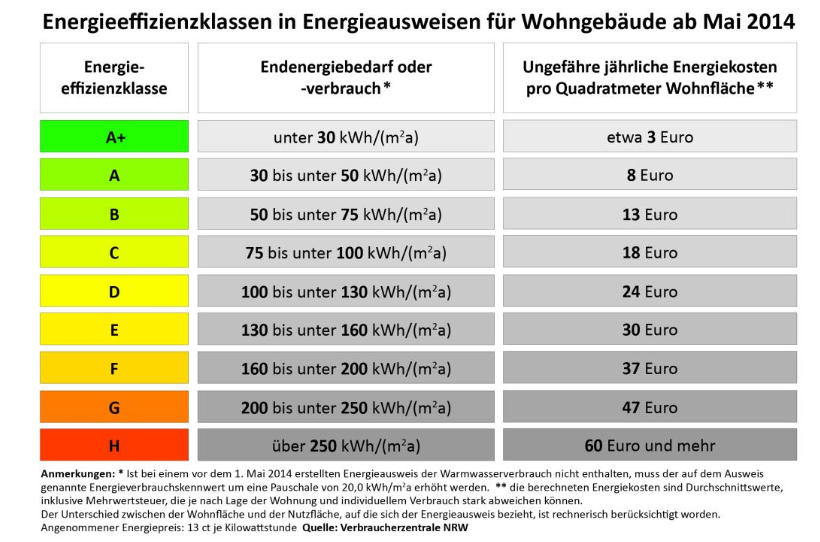

In [ ]:
# Empfohlene thermal_char-Werte je nach Energieklasse
energy_class_to_thermal = {
    'A+': 25,
    'A': 40,
    'B': 62.5,
    'C': 87.5,
    'D': 115,
    'E': 145,
    'F': 180,
    'G': 225,
    'H': 275
}

# Füllen die Zeilen mit fehlendem Thermal_Char mit den entsprechenden Werten in der Energieeffizienzklasse
for cls, val in energy_class_to_thermal.items():
    mask = (df["thermal_char"].isna()) & (df["energy_efficiency_class"] == cls)
    df.loc[mask, "thermal_char"] = val


In [ ]:
# Verwenden wir den Median, um fehlende Thermalzeichen auszufüllen
thermal_medians = df.groupby(['regio_2', pd.cut(df['living_space'], bins=5)])['thermal_char'].median()
# Teilen wir den Wohnraum in Kategorien ein
df['living_space_bin'] = pd.cut(df['living_space'], bins=5)

def fill_thermal(row):
    if pd.isna(row['thermal_char']):
        return thermal_medians.get((row['regio_2'], row['living_space_bin']), np.nan)
    else:
        return row['thermal_char']

df['thermal_char'] = df.apply(fill_thermal, axis=1)

In [ ]:
# Region bazlı median hesapla
region_medians = df.groupby('regio_2')['thermal_char'].median()

# Eksik thermal_char olanları sadece region_combo bazlı doldur
df.loc[df['thermal_char'].isna(), 'thermal_char'] = df.loc[df['thermal_char'].isna(), 'regio_2'].map(region_medians)

In [ ]:
df['thermal_char'].isna().sum()

### 1.5.14. energy_efficiency_class

In [ ]:
first_looking("energy_efficiency_class")

In [ ]:
plot_categorical_distributions(df, 'energy_efficiency_class')

In [ ]:
def map_energy_class(value):
    if pd.isna(value):
        return np.nan
    elif value < 30:
        return 'A_PLUS'
    elif value < 50:
        return 'A'
    elif value < 75:
        return 'B'
    elif value < 100:
        return 'C'
    elif value < 130:
        return 'D'
    elif value < 160:
        return 'E'
    elif value < 200:
        return 'F'
    elif value < 250:
        return 'G'
    else:
        return 'H'

mask = df['energy_efficiency_class'].isna() & df['thermal_char'].notna()
df.loc[mask, 'energy_efficiency_class'] = df.loc[mask, 'thermal_char'].apply(map_energy_class)

In [ ]:
df['energy_efficiency_class'].isna().sum()

### 1.5.15. last_refurbish

In [ ]:
first_looking("last_refurbish")

In [ ]:
# Datentyp ändern
df['last_refurbish'] = df['last_refurbish'].astype('Int64')

In [ ]:
def extract_refurbish_year(text):
    if pd.isna(text):
        return None
    # Regex: 19xx oder 20xx nach typischen Stichwörtern
    match = re.search(r'(renoviert|saniert|modernisiert)[^\d]*(19|20)\d{2}', text.lower())
    if match:
        return int(re.search(r'(19|20)\d{2}', match.group()).group())
    return None

# Beschreibung und Ausstattungen kombinieren
df['combined_text'] = df[['description', 'facilities']].fillna('').agg(' '.join, axis=1)

# Jahr extrahieren
df['refurbish_from_text'] = df['combined_text'].apply(extract_refurbish_year)

# Leere refurbish-Felder mit extrahierten Werten auffüllen
df['last_refurbish'] = df['last_refurbish'].combine_first(df['refurbish_from_text'])


In [ ]:
df['last_refurbish'].isna().sum()

In [ ]:
# Kategorisierung nach Jahr
def refurbish_category(year):
    if pd.isna(year):
        return 'unknown'
    elif year >= 2015:
        return 'new'
    elif year >= 2000:
        return 'moderate'
    elif year >= 1980:
        return 'old'
    else:
        return 'very_old'

df['refurbish_category'] = df['last_refurbish'].apply(refurbish_category)


In [ ]:
df['refurbish_category'].value_counts()

In [ ]:
df.loc[
    (df['refurbish_category'] == 'unknown') & (df['newly_const'] == True),
    'refurbish_category'
] = 'new'

In [ ]:
df.loc[
    (df['refurbish_category'] == 'unknown') & (df['year_constructed'] >= 2010),
    'refurbish_category'
] = 'new'

In [ ]:
df['refurbish_category'].value_counts()

In [ ]:
plot_categorical_distributions(df, 'refurbish_category')

## 1.5.16. firing_types

In [ ]:
first_looking("firing_types")

In [ ]:
df['firing_types'].value_counts().index.tolist()

In [ ]:
def categorize_firing_type(value):
    if pd.isna(value):
        return 'no_information'
    value = value.lower()
    
    if value == 'district_heating':
        return 'district_heating'
    
    if 'district_heating' in value and ':' in value:
        parts = value.split(':')
        for part in parts:
            if part != 'district_heating':
                value = part
                break
    
    renewable_keywords = ['pellet', 'geothermal', 'bio_energy', 'wind_energy', 
                          'hydro_energy', 'environmental_thermal_energy', 'wood', 'wood_chips',
                          'combined_heat_and_power_renewable_energy', 'combined_heat_and_power_bio_energy']
    if any(keyword in value for keyword in renewable_keywords):
        return 'renewable_energy'
    
    if 'solar_heating' in value:
        return 'solar_heating'
    
    if 'gas' in value:
        return 'gas'
    if 'electricity' in value:
        return 'electricity'
    if 'oil' in value:
        return 'oil'
    
    fossil_fuel_keywords = ['combined_heat_and_power_fossil_fuels', 'coal', 'coal_coke']
    if any(keyword in value for keyword in fossil_fuel_keywords):
        return 'fossil_fuels'
    
    # Diğer tüm durumlar 'other'
    return 'other'

df['firing_types_simplified'] = df['firing_types'].apply(categorize_firing_type)
df['firing_types_simplified'].fillna('no_information', inplace=True)

print(df['firing_types_simplified'].value_counts())


In [ ]:
patterns = {
    'gas': ['gas'],
    'district_heating': ['district heating', 'fernwärme'],  # district heating için Almanca da ekledim
    'oil': ['oil', 'öl'],
    'renewable_energy': ['pellet', 'geothermal', 'bio energy', 'wind', 'hydro', 'environmental thermal', 'wood'],
    'electricity': ['electricity', 'strom'],
    'fossil_fuels': ['coal', 'coal coke', 'combined heat and power fossil fuels', 'fossil fuels'],
    'solar_heating': ['solar heating', 'solar'],
}

def assign_category_from_description(row):
    if row['firing_types_simplified'] != 'no_information':
        return row['firing_types_simplified']
    
    desc = str(row['description']).lower()
    for category, keys in patterns.items():
        for key in keys:
            if re.search(r'\b' + re.escape(key) + r'\b', desc):
                return category
    return 'no_information'

df['firing_types_simplified'] = df.apply(assign_category_from_description, axis=1)

print(df['firing_types_simplified'].value_counts())

In [ ]:
plot_categorical_distributions(df, 'firing_types_simplified')

### 1.5.17. heating_type_cleaned

In [ ]:
first_looking("heating_type_cleaned")

In [ ]:
def fill_heating_type(row):
    if pd.notna(row['heating_type_cleaned']):
        return row['heating_type_cleaned']
    
    # basierend auf firing_types_simplified
    category = row['firing_types_simplified']
    
    if category == 'district_heating':
        return 'district_heating'
    elif category == 'gas':
        return 'gas_heating'
    elif category == 'oil':
        return 'oil_heating'
    elif category == 'electricity':
        return 'central_heating'  
    elif category == 'renewable_energy':
        return 'heat_pump' 
    else:
        return np.nan  

df['heating_type_cleaned'] = df.apply(fill_heating_type, axis=1)

In [ ]:
df['heating_type_cleaned'].value_counts(dropna=False)

In [ ]:
df.loc[
    (df['heating_type_cleaned'].isna()) & (df['newly_const'] == True),
    'heating_type_cleaned'
] = 'heat_pump'

In [ ]:
df['heating_type_cleaned'].value_counts(dropna=False)

In [ ]:
df.loc[
    (df['heating_type_cleaned'].isna()) &
    (df['year_category'].isin(['very_old', 'old', 'historical'])),
    'heating_type_cleaned'
] = 'oil_heating'

# Moderate olanlara gas_heating
df.loc[
    (df['heating_type_cleaned'].isna()) &
    (df['year_category'] == 'moderate'),
    'heating_type_cleaned'
] = 'gas_heating'

# New veya very_new olanlara heat_pump
df.loc[
    (df['heating_type_cleaned'].isna()) &
    (df['year_category'].isin(['new', 'very_new'])),
    'heating_type_cleaned'
] = 'heat_pump'

In [ ]:
df['heating_type_cleaned'].value_counts(dropna=False)

In [ ]:
df['heating_type_cleaned'].fillna('other_heating', inplace=True)

In [ ]:
plot_categorical_distributions(df, 'heating_type_cleaned')

### 1.5.18. description

In [ ]:
first_looking("description")

In [ ]:
# Fehlende Werte in der Spalte 'description' mit 'no_description' ersetzen
df['description'].fillna('no_description', inplace=True)

### 1.5.19. facilities

In [ ]:
first_looking("facilities")

In [ ]:
# Fehlende Werte in der Spalte 'facilities' mit 'no_information' ersetzen
df['facilities'].fillna('no_information', inplace=True)

# 2. Abschluss und Auswertung

**💡 Zusammenfassung der Datenbereinigung und Handhabung der fehlenden Werten:**

✔️ In diesem Schritt der Datenvorverarbeitung wurden folgende Maßnahmen durchgeführt:

✔️ Fehlende Werte wurden analysiert und – sofern sinnvoll – imputiert oder bereinigt.

✔️ Nicht relevante oder redundant fehlende Spalten wurden entfernt, um die Datenstruktur zu vereinfachen.

✔️ Die Spaltennamen wurden einheitlich, leserlich und modellfreundlich umbenannt.

✔️ Es erfolgte eine klare Unterscheidung und Verarbeitung von kategorialen und numerischen Variablen.

✔️ Neue Merkmale (Features) wurden erstellt, z. B. condition_grouped, year_category oder upload_speed_category.


📌 Hinweis: Die Analyse und Bereinigung von Ausreißern (Ausreißerbehandlung) wird in Notebook 3 separat behandelt.

Der Datensatz ist damit für die nächste Phase der Modellierung vorbereitet – einschließlich Feature-Selection, Visualisierung und Modelltraining.

In [ ]:
df.drop(columns=["year_constructed", "refurbish_from_text", "combined_text", "last_refurbish", "living_space_bin", "firing_types", "street_plain", "date_parsed"], inplace=True)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.duplicated(keep=False).sum()

In [ ]:
df = df.drop_duplicates()

In [ ]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def check_obj_columns(df):
    '''
    Returns NO PROBLEM or column/s which has/have mixed object types.
    '''    
    
    tdf = df.select_dtypes(include=['object']).applymap(type)
    for col in tdf:
        if len(set(tdf[col].values)) > 1:
            print("Column" + " " + color.BOLD + color.RED + col + color.END + " " + "has mixed object types." )
    else:
        if len(set(tdf[col].values)) == 1:
            print(color.BOLD + color.GREEN + " " + "NO PROBLEM" + " " + color.END + " " + "with the data types of Columns in the DataFrame.")

check_obj_columns(df)

In [ ]:
df.to_csv('filling_immo_data.csv', index=False)

<a id="10"></a>

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#9d4f8c; font-size:150%; text-align:center; border-radius:10px 10px;">Das Ende der Handhabung fehlender Werte (Teil 02)</p>